**Auteur** : Viktoriya Zeruk<br>
**Date dernière version** : 12/07/2022<br>

# <center><font color=#7DF9FF>Projet 5: <br>Catégorisez automatiquement des questions</font> </center>

<img src="https://user.oc-static.com/upload/2022/03/23/16480242457412_Screenshot%202022-03-23%20at%2009.30.21.png" alt="">

## Les données

Stack Overflow propose un outil d’export de données, [StackExchange Data Explorer](https://data.stackexchange.com/stackoverflow/query/new), qui recense un grand nombre de données authentiques de la plateforme d’entraide.

## Contexte

Afin de permettre de faciliter le parcours des utilisateurs de l'outil communautaire Stack Overflow nous avons travaillé sur la mise à disposition d'un *système de suggestion de tags*.

# <center><font color=#15f4ee> Analyse exploratoire des données</font></center>

## Importation des données

Nous avons récupéré l'ensemble des posts sur la période janvier 2009 à juillet 2022. Nous avons utilisé l'outil  [stackexchange explorer](https://data.stackexchange.com/stackoverflow/query/new) afin de récupére l'ensemble des posts publiés entre janvier 2009 et juillet 2022.  Nous avons donc réalisé une requête par an avec les critères suivants:

- Ayant un Score > 5
- Ayant un nombre de vues > 20
- Ayant un nombre de réponses > 1
- Ayant un nombre de commentaires > 5



Ci-dessous un exemple de requête :


DECLARE @start_date DATE

DECLARE @end_date DATE

SET @start_date = '2011-01-01'

SET @end_date = DATEADD(m , 12 , @start_date)


SELECT p.Id, p.CreationDate, p.Title, p.Body, p.Tags,

p.ViewCount, p.CommentCount, p.AnswerCount, p.Score 

FROM Posts as p LEFT JOIN PostTypes as t ON p.PostTypeId = t.id

WHERE p.CreationDate between @start_date and @end_date

AND t.Name = 'Question‘ AND p.ViewCount > 20 AND p.CommentCount > 5 AND p.AnswerCount > 1

AND p.Score > 5 AND len(p.Tags) > 0


ORDER BY CreationDate 

Après la collecte de l'ensemble des fichiers CSV nous récupérons toutes les observations dans un dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil, sqrt, floor

from PIL import Image

import time
import datetime as dt
from datetime import date, timedelta

from bs4 import BeautifulSoup

from wordcloud import WordCloud

from sklearn.preprocessing import KBinsDiscretizer

from langdetect import detect

import os
import warnings
warnings.filterwarnings('ignore')
import IPython.display



print('### Data files ###')
for idx, file in enumerate(os.listdir('./data')):
    print(idx, '-', file)
print('\n' + '-' *50 +'\n')

data = pd.DataFrame()

for idx, file in enumerate(os.listdir('./data')):
    path = './data/' + file
    df = pd.read_csv(path,
                     index_col = 0,
                     parse_dates=['CreationDate'],
                     na_values = 'NaN'
                    )
        
    data = pd.concat([data, df],
                      axis=0)
    
na_body_idx = data[data['Body'].isna()==True].index
data.drop(index = na_body_idx, inplace=True)
data.sort_values('CreationDate', inplace=True)
print("Dix premières valeurs du dataset")
display(data.head(10))
print('\n' + '-' *50 +'\n')
print(f"Nombre d'observations: {data.shape[0]}, nombre de variables: {data.shape[1]}")

### Data files ###
0 - StackOverflow_questions_2009.csv
1 - StackOverflow_questions_2010.csv
2 - StackOverflow_questions_2011.csv
3 - StackOverflow_questions_2012.csv
4 - StackOverflow_questions_2013.csv
5 - StackOverflow_questions_2014.csv
6 - StackOverflow_questions_2015.csv
7 - StackOverflow_questions_2016.csv
8 - StackOverflow_questions_2017.csv
9 - StackOverflow_questions_2018.csv
10 - StackOverflow_questions_2019.csv
11 - StackOverflow_questions_2020.csv
12 - StackOverflow_questions_2021.csv
13 - StackOverflow_questions_2022.csv

--------------------------------------------------

Dix premières valeurs du dataset


,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score
Id,,,,,,,,
405165,2009-01-01 17:12:12,"Please advise on Ruby vs Python, for someone w...","<p>I am a C++ developer, slowly getting into w...",<python><ruby><lisp>,5629,6,12,21
405548,2009-01-01 22:10:48,C# - are all Enum constants?,<p>Are all Enum enumerations constants? Do the...,<.net><enums>,2161,8,2,12
405770,2009-01-02 01:01:36,Why are compilers so stupid?,<p>I always wonder why compilers can't figure ...,<performance><language-agnostic><compiler-cons...,8100,12,29,41
406016,2009-01-02 04:27:30,UI Terminology: Logon vs Login,<p>I am crafting an application and cannot dec...,<user-interface><terminology>,85605,14,13,350
406121,2009-01-02 05:40:31,Flattening a shallow list in Python,<p>Is there a simple way to flatten a list of ...,<python><list-comprehension>,188977,7,23,401
406230,2009-01-02 07:30:16,Regular expression to match a line that doesn'...,<p>I know it's possible to match a word and th...,<regex><regex-negation>,3830282,6,31,4651
407518,2009-01-02 17:42:45,Code Golf: Leibniz formula for Pi,"<p>I recently posted <a href=""https://stackove...",<code-golf><rosetta-stone>,14651,8,46,31
407523,2009-01-02 17:44:15,Escape a string for a sed replace pattern,<p>In my bash script I have an external (recei...,<string><sed><escaping>,321410,6,15,350
407929,2009-01-02 20:21:47,How do I change Eclipse to use spaces instead ...,"<p>By default <a href=""http://en.wikipedia.org...",<eclipse><formatting><tabs><whitespace>,525044,15,21,914



--------------------------------------------------

Nombre d'observations: 104392, nombre de variables: 8


## Test des valeurs manaquantes

Avant tout traitement nous souhaitons savoir si certaines observations variables sont manquantes.

In [2]:
def test_completion(data):
    """
    Compute sorted completion rate and number of missing values for each variable of the argument in a descending order
    
    Args:
        data(dataset) : A dataset with variables
        
    Returns:
        A specific dataframe with completion rate for each variable. 
        Schema :
            Index(string): Variable names
            Taux de completion(float): completion rate
            Nombre de valeurs manquantes(int): Number of missing values
    """
    var_dict = {}
    
    for col in data.columns:
        var_dict[col] = []
        var_dict[col].append(round((data[col].notna().sum()/data.shape[0])*100,2))
        var_dict[col].append(data[col].isna().sum())
        
    return pd.DataFrame.from_dict(data=var_dict, orient="index", columns = ["Taux de complétion", "Nombre de valeurs manquantes"]).sort_values(by="Taux de complétion", ascending=False)

test_completion(data)

,Taux de complétion,Nombre de valeurs manquantes
CreationDate,100.0,0
Title,100.0,0
Body,100.0,0
Tags,100.0,0
ViewCount,100.0,0
CommentCount,100.0,0
AnswerCount,100.0,0
Score,100.0,0


Nous ne constatons aucune valeur manquante


## <span style="color: lightgreen" >Analyse statistique des variables quantitatives : </span>

##### Définition d'une fonction `outliers_analyse()` qui calcule la moyenne, la médiane, l'écart type, le Q1, le Q3, l'écart interquartile, la valeur minimale et la valeur maximale et qui affiche un histogramme, un KDE et un boxplot pour chacune des variables quantitatives d'une base de donnée correspondant au type renseigné. 

In [3]:
def outliers_analyse(df, typage="type_var"):
    df_type = df.dtypes
    df_type_list = df_type[df_type == typage]
    for i in df_type_list.index:
        print("Variable: ", i)
        parameters = {"xtick.labelsize": 18, "ytick.labelsize": 18}
        plt.rcParams.update(parameters)
        mo = df[i].mean()
        print("\n(count) La moyenne de", i, "est égale à:", mo)
        me = df[i].median()
        print("(50%) La médiane de", i, "est égale à:", me)
        me = df[i].std()
        print("(std) Écart type de", i, "est égale à:", me)
        mini = df[i].min()
        Q1 = round(np.percentile(df[i], 25))
        print("(25%) Quartile Q1 de", i, "vaut : ", Q1)
        Q3 = round(np.percentile(df[i], 75))
        print("(75%) Quartile Q3 de", i, "vaut : ", Q3)
        print("L ecart interquartile vaut : ", Q3 - Q1)
        print("La valeur minimale de", i, "est égale à:", mini)
        maxi = df[i].max()
        print("La valeur maximale de", i, "est égale à:", maxi)
        print("\nHistogramme représentant les valeurs de la variable", i)
        df[i].plot.hist()
        plt.show()
        print("\nTracé du KDE avec noyaux gaussiens", i)
        df[i].plot.kde()
        plt.show()
        print("\nBoxplot représentant les valeurs de la variable", i)
        df.boxplot(column=i, showfliers=True, vert=False)
        plt.show()
        print("--" * 50)
        print("\n")

Variable:  ViewCount

(count) La moyenne de ViewCount est égale à: 33363.79885431834
(50%) La médiane de ViewCount est égale à: 7025.5
(std) Écart type de ViewCount est égale à: 133825.0783954499
(25%) Quartile Q1 de ViewCount vaut :  2132
(75%) Quartile Q3 de ViewCount vaut :  22413
L ecart interquartile vaut :  20281
La valeur minimale de ViewCount est égale à: 39
La valeur maximale de ViewCount est égale à: 9565025

Histogramme représentant les valeurs de la variable ViewCount


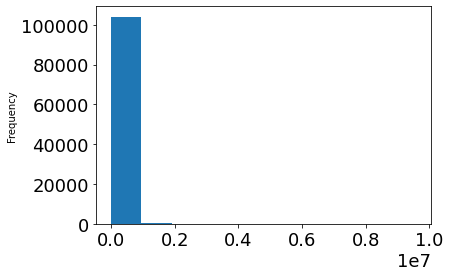


Tracé du KDE avec noyaux gaussiens ViewCount


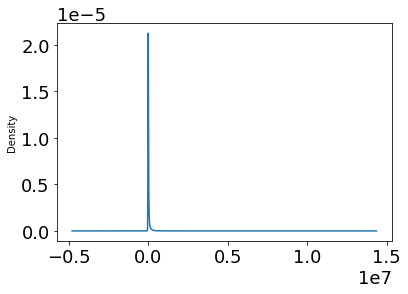


Boxplot représentant les valeurs de la variable ViewCount


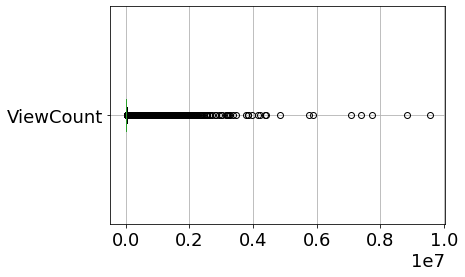

----------------------------------------------------------------------------------------------------


Variable:  CommentCount

(count) La moyenne de CommentCount est égale à: 8.819143229366235
(50%) La médiane de CommentCount est égale à: 8.0
(std) Écart type de CommentCount est égale à: 3.7530832725300565
(25%) Quartile Q1 de CommentCount vaut :  6
(75%) Quartile Q3 de CommentCount vaut :  10
L ecart interquartile vaut :  4
La valeur minimale de CommentCount est égale à: 6
La valeur maximale de CommentCount est égale à: 89

Histogramme représentant les valeurs de la variable CommentCount


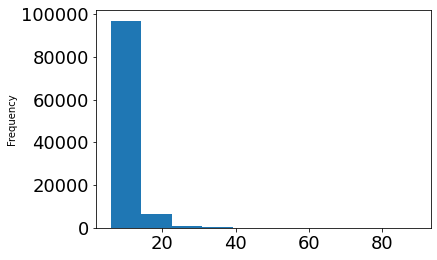


Tracé du KDE avec noyaux gaussiens CommentCount


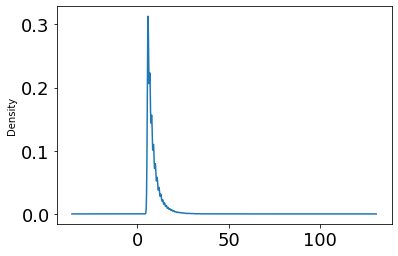


Boxplot représentant les valeurs de la variable CommentCount


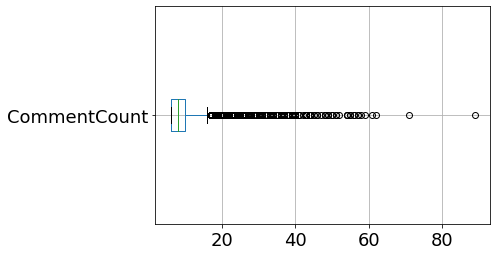

----------------------------------------------------------------------------------------------------


Variable:  AnswerCount

(count) La moyenne de AnswerCount est égale à: 4.899934860908882
(50%) La médiane de AnswerCount est égale à: 3.0
(std) Écart type de AnswerCount est égale à: 4.887018210842207
(25%) Quartile Q1 de AnswerCount vaut :  2
(75%) Quartile Q3 de AnswerCount vaut :  6
L ecart interquartile vaut :  4
La valeur minimale de AnswerCount est égale à: 2
La valeur maximale de AnswerCount est égale à: 163

Histogramme représentant les valeurs de la variable AnswerCount


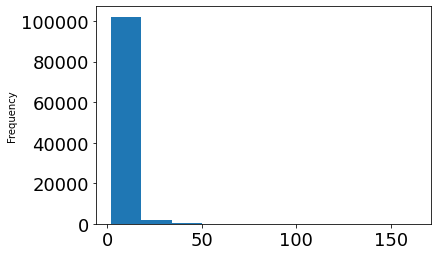


Tracé du KDE avec noyaux gaussiens AnswerCount


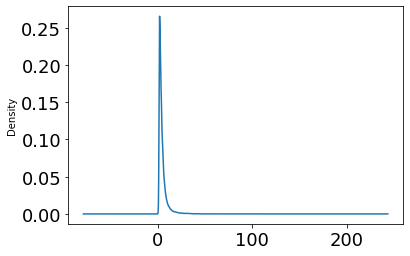


Boxplot représentant les valeurs de la variable AnswerCount


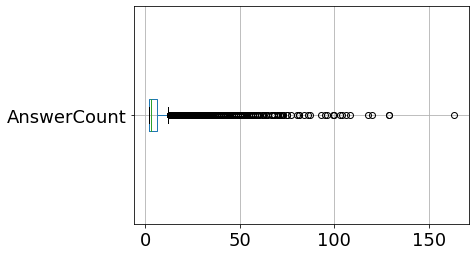

----------------------------------------------------------------------------------------------------


Variable:  Score

(count) La moyenne de Score est égale à: 37.3652578741666
(50%) La médiane de Score est égale à: 12.0
(std) Écart type de Score est égale à: 187.29147816459377
(25%) Quartile Q1 de Score vaut :  8
(75%) Quartile Q3 de Score vaut :  23
L ecart interquartile vaut :  15
La valeur minimale de Score est égale à: 6
La valeur maximale de Score est égale à: 25552

Histogramme représentant les valeurs de la variable Score


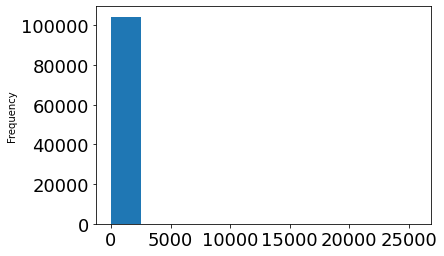


Tracé du KDE avec noyaux gaussiens Score


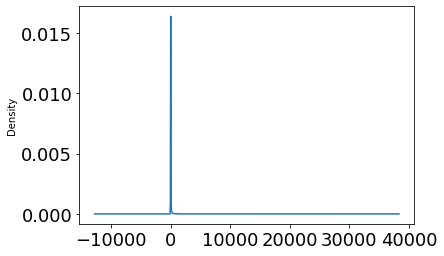


Boxplot représentant les valeurs de la variable Score


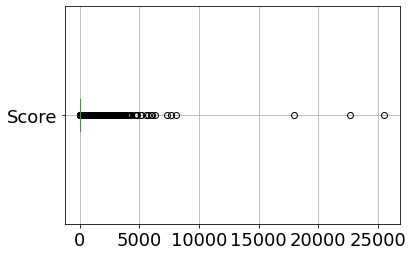

----------------------------------------------------------------------------------------------------




In [4]:
outliers_analyse(data, typage="int64")

In [5]:
col1 = ["ViewCount","AnswerCount","Score"]

##### Définition d'une fonction `multi_histo()` qui trace des histogrammes des variables quantitatives de la base de données.

In [6]:
def multi_histo(df, cols, nb_cols, larg, haut, colour="colour", title="title"):
    num_plots = len(cols)
    num_cols = nb_cols
    num_rows = ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(larg, haut))
    fig.suptitle(title, fontsize=32, x=0.5, y=0.95)

    for ind, col in enumerate(cols):
        i = floor(ind / num_cols)
        j = ind - i * num_cols

        if num_rows == 1:
            if num_cols == 1:
                sns.histplot(df[col], color=colour, ax=axs, bins=100, kde=True)
                ax = axs
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
            else:
                sns.histplot(df[col], color=colour, ax=axs[j], bins=100, kde=True)
                ax = axs[j]
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
        else:
            sns.histplot(df[col], color=colour, ax=axs[i, j], bins=100, kde=True)
            ax = axs[i, j]
            ax.set_xlabel(col, fontdict={"fontsize": 18})
            ax.set_ylabel("")


##### Définition d'une fonction `multi_box()` qui trace des boîtes à moustaches des variables quantitatives de la base de données.

In [7]:
def multi_box(df, cols, nb_cols, larg, haut, colour="colour", title="title"):
    num_plots = len(cols)
    num_cols = nb_cols
    num_rows = ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(larg, haut))
    fig.suptitle(title, fontsize=32, x=0.5, y=0.95)

    for ind, col in enumerate(cols):
        i = floor(ind / num_cols)
        j = ind - i * num_cols

        if num_rows == 1:
            if num_cols == 1:
                sns.boxplot(x=df[col], color=colour, ax=axs, showfliers=False)
                ax = axs
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
            else:
                sns.boxplot(x=df[col], color=colour, ax=axs[j], showfliers=False)
                ax = axs[j]
                ax.set_xlabel(col, fontdict={"fontsize": 18})
                ax.set_ylabel("")
        else:
            sns.boxplot(x=df[col], color=colour, ax=axs[i, j], showfliers=False)
            ax = axs[i, j]
            ax.set_xlabel(col, fontdict={"fontsize": 18})
            ax.set_ylabel("")

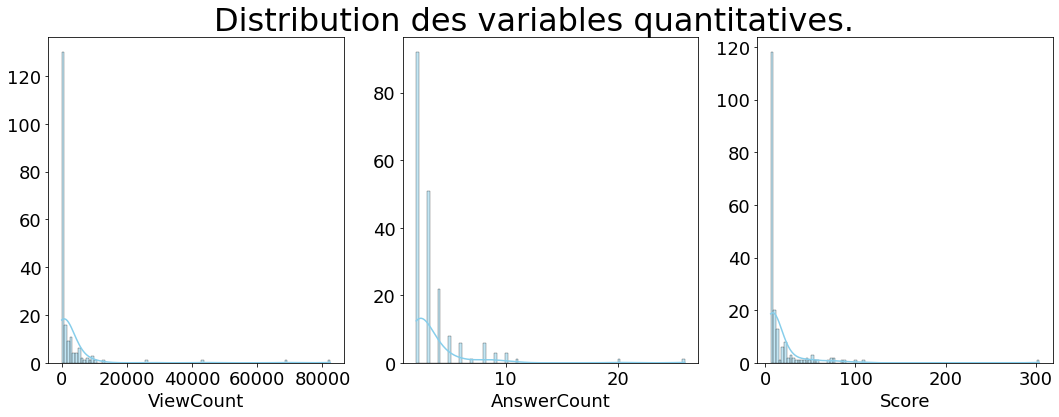

In [8]:
multi_histo(
    df,
    col1,
    3,
    18,
    6,
    colour="skyblue",
    title="Distribution des variables quantitatives.",
)

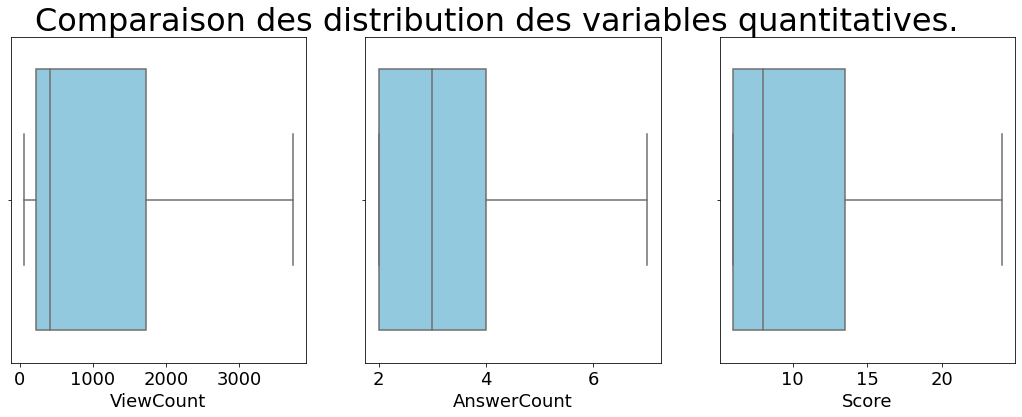

In [9]:
multi_box(
    df,
    col1,
    3,
    18,
    6,
    colour="skyblue",
    title="Comparaison des distribution des variables quantitatives.",
)

### CreationDate

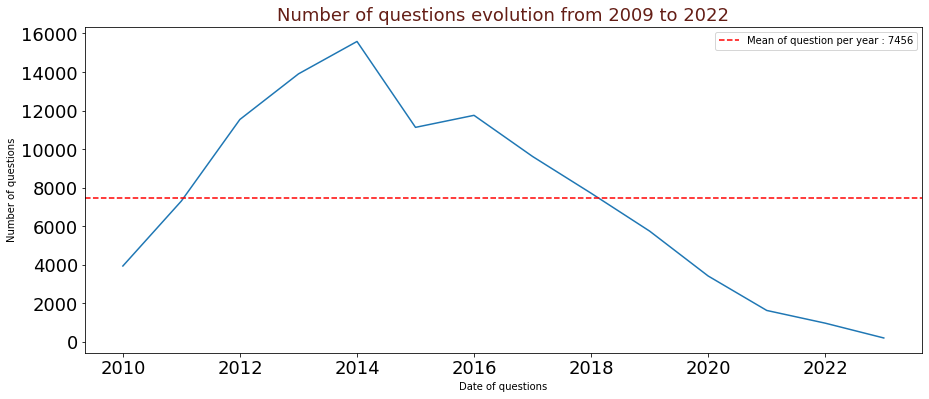

In [10]:
# Convert CreationDate to datetime format
df['CreationDate'] = pd.to_datetime(data['CreationDate'])

# Grouper with 1 year delta
post_year = data.groupby(pd.Grouper(key='CreationDate',
                                    freq='1Y')).agg({'Title': 'count'})

# Plot evolution
fig = plt.figure(figsize=(15,6))
sns.lineplot(data=post_year, x=post_year.index, y='Title')
plt.axhline(post_year.Title.mean(), 
            color="r", linestyle='--',
            label="Mean of question per year : {:04d}"\
                   .format(int(post_year.Title.mean())))
plt.xlabel("Date of questions")
plt.ylabel("Number of questions")
plt.title("Number of questions evolution from 2009 to 2022",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

On remarque ici que sur nos critères de sélection, le nombre de questions posées a tendance à diminuer de manière constante depuis 2014.

Using matplotlib backend: <object object at 0x00000233218C2AB0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


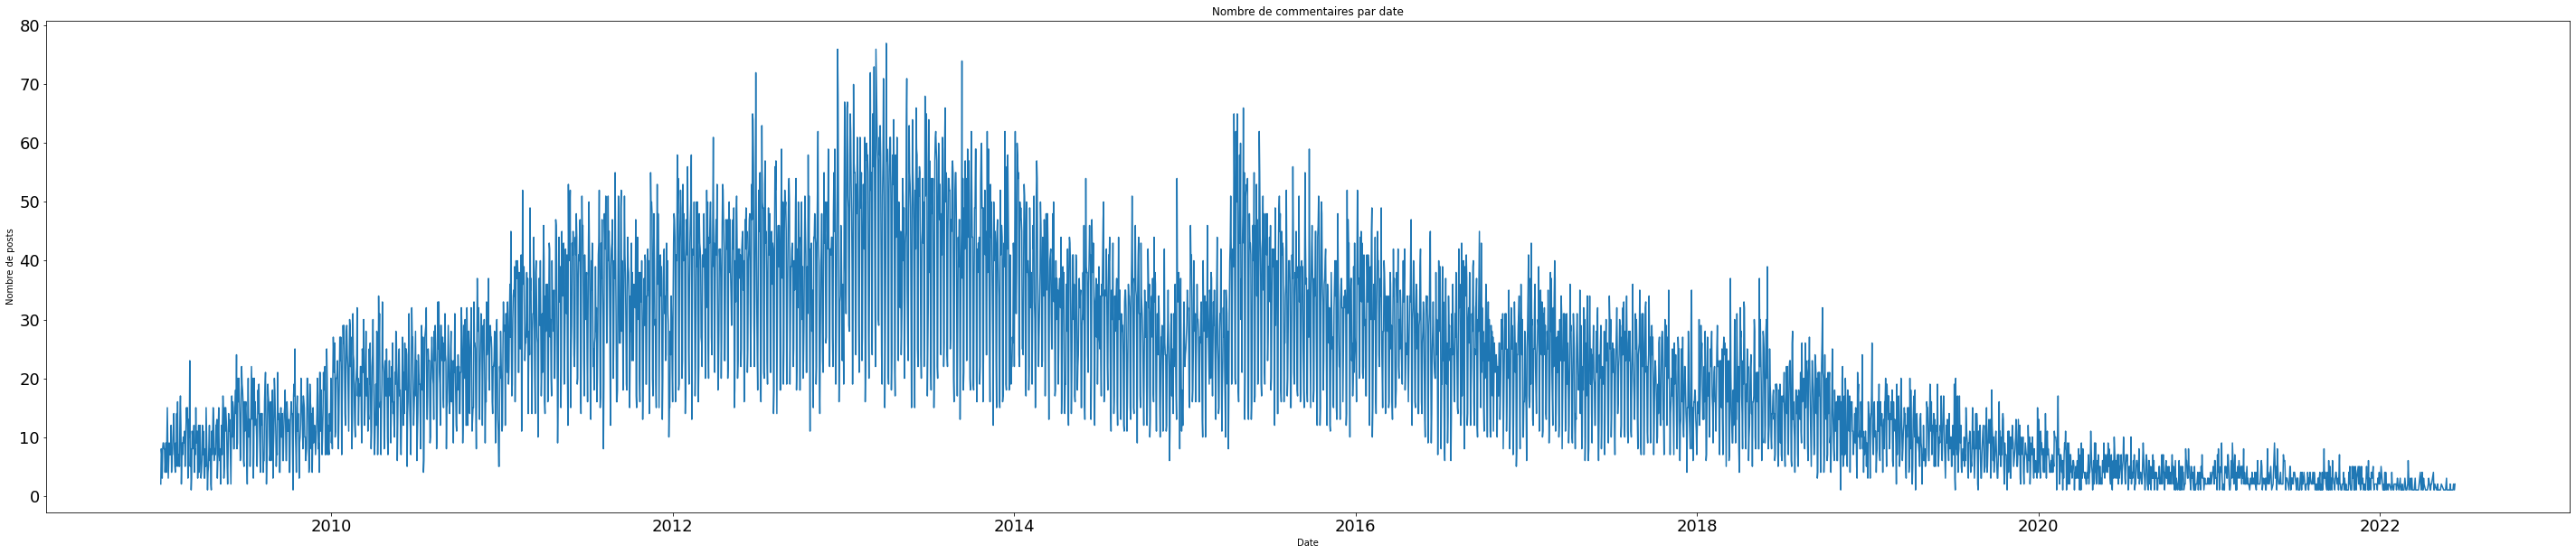

In [11]:
%pylab 
%matplotlib inline
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(50,10))
CreationDateByDay = data['CreationDate'].dt.date.value_counts()

sns.lineplot(data=CreationDateByDay, x=CreationDateByDay.index, y=CreationDateByDay.values, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Nombre de posts")
ax.set_title("Nombre de commentaires par date")

plt.show()

Nous constatons une baisse d’activité sur la période. 

Nous pouvons en déduire une proportion de posts décroissante dans le temps. Donc, filtrer les posts par date de création pénaliserait les publications les plus récentes et les thématiques qui y sont associées.

### ViewCountByDay

Nous estimons que le ViewCount peu représenter un biais dans la mesure que des posts plus anciens ont potentiellement une propention à avoir un ValueCount plus élevé. Afin de vérifier l'hypothèse nous procédons de la sorte:
- Construction d'une variable CreationDateTimeDelta : différence entre la valeur maximum de CreationDate et valeur CreationDate de chaque observation
- Visualisation la distribution des points entre les variables ViewCount et CreationDateTimeDelta

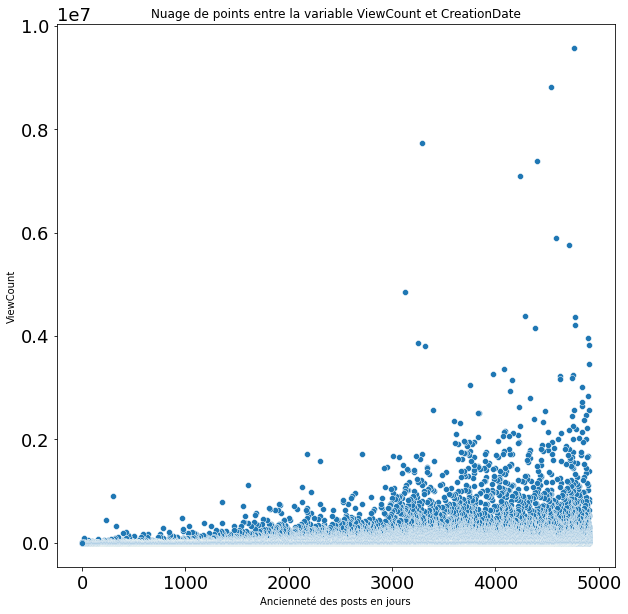

In [12]:
last_post = data["CreationDate"].max()
data["CreationDateTimeDelta"] = last_post - data["CreationDate"]
data["CreationDateTimeDelta"] = data["CreationDateTimeDelta"].dt.days

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
sns.scatterplot(data=data, x="CreationDateTimeDelta", y="ViewCount", ax=ax)
ax.set_xlabel("Ancienneté des posts en jours")
ax.set_label("Nombre de vues")
ax.set_title("Nuage de points entre la variable ViewCount et CreationDate")
plt.show()

Nous n'observons pas de corrélation linéaire nette entre les deux variables sur l'ensemble des observations. Un phénomène est toutefois constatable sur certaines observations. Afin d'apprécier les corrélations, nous réalisons un des test de Pearson et de Spearman.

In [13]:
def corr_test(var1, var2, method='pearson'):
    """
    Statistical correlation test between two variables.
    
    Args:
        var1(dataframe Series): First Series to check correlation
        
        var2(dataframe Series): Second Series to check correlation
        
        method: Used method to compute correlation metric between 'pearson' and 'spearman'
        
    Returns:
        stat(float): Computed correlation metric
        
        p(float): Computed p value
    
    """
    import scipy.stats as st
    print("-"*50)
    if method == 'pearson':
        print(f"Test statistique de corrélation linéaire de Pearson entre {var1.name} et {var2.name}\n")
        stat, p = st.pearsonr(var1,var2)
        print(f"""Coeficient de corrélation linéaire de Pearson: {stat}\n p valeur: {p}\n""")
        if p < 0.05:
            print("L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%\n" )
        if p > 0.05:
            print("L'hypothèse H0 d'indépendance ne peut être rejetée avec un risque de 5\n")
    if method == 'spearman':
        print(f"Test statistique de corrélation de rang de Spearman entre {var1.name} et {var2.name}\n")
        stat, p = st.spearmanr(var1,var2)
        print(f"""Coeficient de corrélation de rang de Spearman: {stat}\n p valeur: {p}\n""")
        if p < 0.05:
            print("L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%\n" )
        if p > 0.05:
            print("L'hypothèse H0 d'indépendance ne peut être rejetée avec un risque de 5\n")       
    print("-"*50)
    
    
    return stat, p

corr_test(data["CreationDateTimeDelta"], data["ViewCount"],'pearson')
corr_test(data["CreationDateTimeDelta"], data["ViewCount"],'spearman')

--------------------------------------------------
Test statistique de corrélation linéaire de Pearson entre CreationDateTimeDelta et ViewCount

Coeficient de corrélation linéaire de Pearson: 0.1430937630119657
 p valeur: 0.0

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------
--------------------------------------------------
Test statistique de corrélation de rang de Spearman entre CreationDateTimeDelta et ViewCount

Coeficient de corrélation de rang de Spearman: 0.2556797955382852
 p valeur: 0.0

L'hypothèse H0 d'indépendance peut être rejetée avec un risque de 5%

--------------------------------------------------


(0.2556797955382852, 0.0)

Les deux tests permettent de rejetter l'indépendance des variables. Ils permettent également de constater une corrélation linéaire faible et une corrélation de rang moyenne entre les deux variables. Afin d'apprécier la pertience d'un post en minimisant l'effet d'ancienneté, nous créons une variable ViewCountByDay. Il s'agit du rapport entre le nombre de vues (ViewCount), et l'ancienneté des posts (CreationDateTimeDelta)

Variable:  ViewCount

(count) La moyenne de ViewCount est égale à: 33363.79885431834
(50%) La médiane de ViewCount est égale à: 7025.5
(std) Écart type de ViewCount est égale à: 133825.0783954499
(25%) Quartile Q1 de ViewCount vaut :  2132
(75%) Quartile Q3 de ViewCount vaut :  22413
L ecart interquartile vaut :  20281
La valeur minimale de ViewCount est égale à: 39
La valeur maximale de ViewCount est égale à: 9565025

Histogramme représentant les valeurs de la variable ViewCount


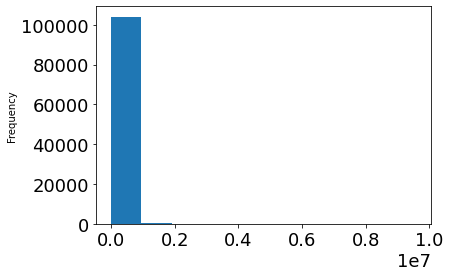


Tracé du KDE avec noyaux gaussiens ViewCount


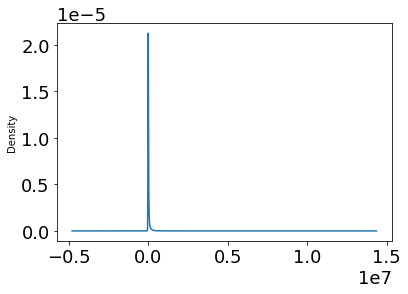


Boxplot représentant les valeurs de la variable ViewCount


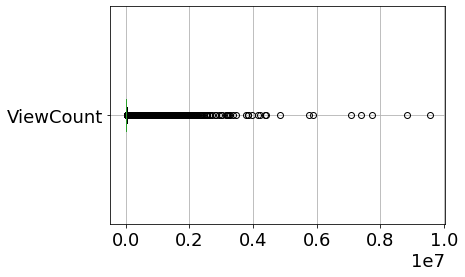

----------------------------------------------------------------------------------------------------


Variable:  CommentCount

(count) La moyenne de CommentCount est égale à: 8.819143229366235
(50%) La médiane de CommentCount est égale à: 8.0
(std) Écart type de CommentCount est égale à: 3.7530832725300565
(25%) Quartile Q1 de CommentCount vaut :  6
(75%) Quartile Q3 de CommentCount vaut :  10
L ecart interquartile vaut :  4
La valeur minimale de CommentCount est égale à: 6
La valeur maximale de CommentCount est égale à: 89

Histogramme représentant les valeurs de la variable CommentCount


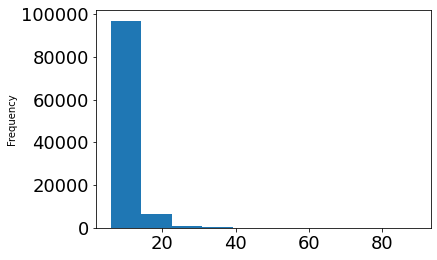


Tracé du KDE avec noyaux gaussiens CommentCount


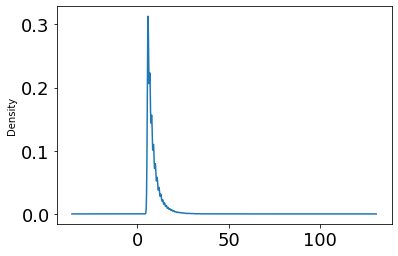


Boxplot représentant les valeurs de la variable CommentCount


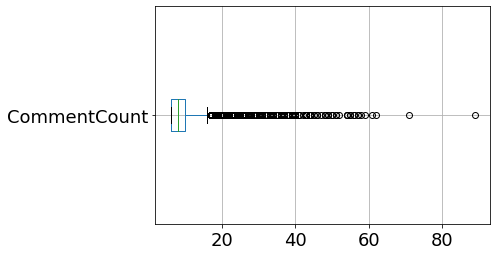

----------------------------------------------------------------------------------------------------


Variable:  AnswerCount

(count) La moyenne de AnswerCount est égale à: 4.899934860908882
(50%) La médiane de AnswerCount est égale à: 3.0
(std) Écart type de AnswerCount est égale à: 4.887018210842207
(25%) Quartile Q1 de AnswerCount vaut :  2
(75%) Quartile Q3 de AnswerCount vaut :  6
L ecart interquartile vaut :  4
La valeur minimale de AnswerCount est égale à: 2
La valeur maximale de AnswerCount est égale à: 163

Histogramme représentant les valeurs de la variable AnswerCount


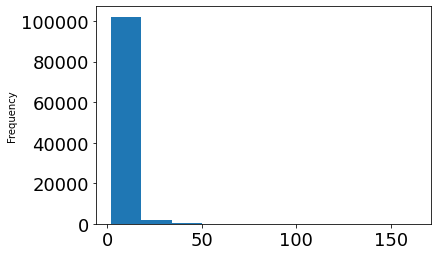


Tracé du KDE avec noyaux gaussiens AnswerCount


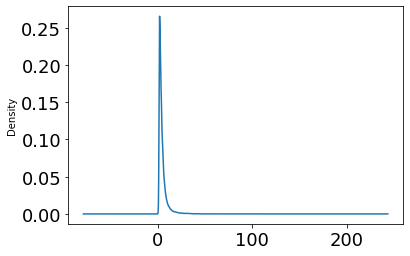


Boxplot représentant les valeurs de la variable AnswerCount


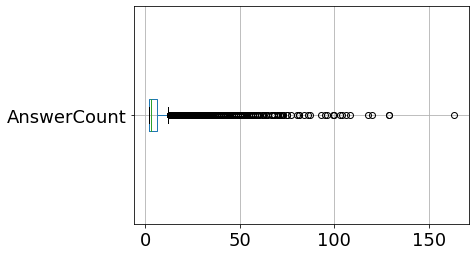

----------------------------------------------------------------------------------------------------


Variable:  Score

(count) La moyenne de Score est égale à: 37.3652578741666
(50%) La médiane de Score est égale à: 12.0
(std) Écart type de Score est égale à: 187.29147816459377
(25%) Quartile Q1 de Score vaut :  8
(75%) Quartile Q3 de Score vaut :  23
L ecart interquartile vaut :  15
La valeur minimale de Score est égale à: 6
La valeur maximale de Score est égale à: 25552

Histogramme représentant les valeurs de la variable Score


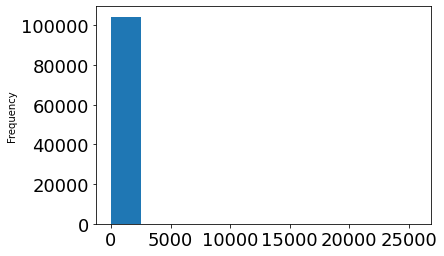


Tracé du KDE avec noyaux gaussiens Score


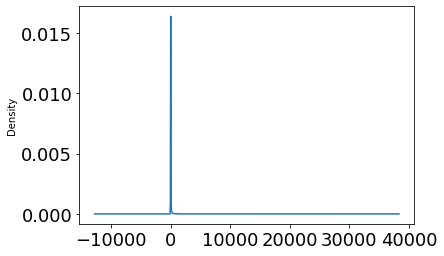


Boxplot représentant les valeurs de la variable Score


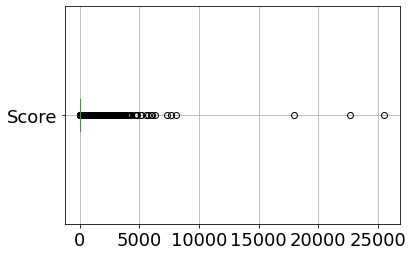

----------------------------------------------------------------------------------------------------


Variable:  CreationDateTimeDelta

(count) La moyenne de CreationDateTimeDelta est égale à: 2956.526046057169
(50%) La médiane de CreationDateTimeDelta est égale à: 3084.0
(std) Écart type de CreationDateTimeDelta est égale à: 1010.4976971918961
(25%) Quartile Q1 de CreationDateTimeDelta vaut :  2248
(75%) Quartile Q3 de CreationDateTimeDelta vaut :  3725
L ecart interquartile vaut :  1477
La valeur minimale de CreationDateTimeDelta est égale à: 0
La valeur maximale de CreationDateTimeDelta est égale à: 4908

Histogramme représentant les valeurs de la variable CreationDateTimeDelta


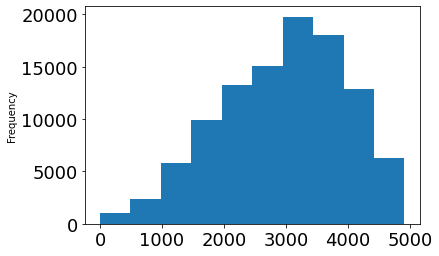


Tracé du KDE avec noyaux gaussiens CreationDateTimeDelta


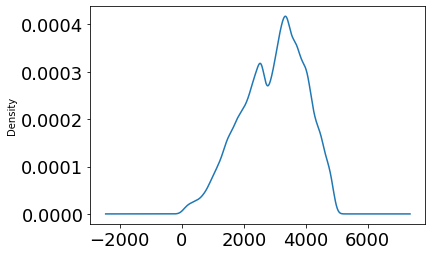


Boxplot représentant les valeurs de la variable CreationDateTimeDelta


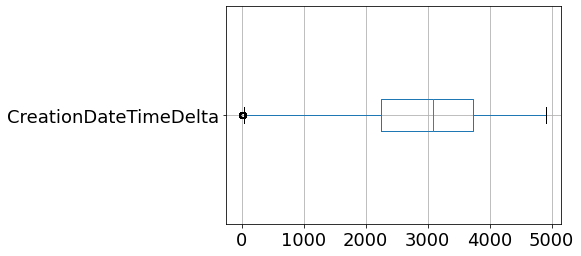

----------------------------------------------------------------------------------------------------




In [14]:
outliers_analyse(data, typage="int64")

In [15]:
data['ViewCountByDay'] =  data['ViewCount'] / (data['CreationDateTimeDelta']+0.000000001)


### Analyse bivariée de l'ensemble des variables quantitatives :

### Corrélations entre les variables numériques

Afin d'évaluer les corrélations entre les variables, nous réalisons les matrices  Pearson et Spearman. 

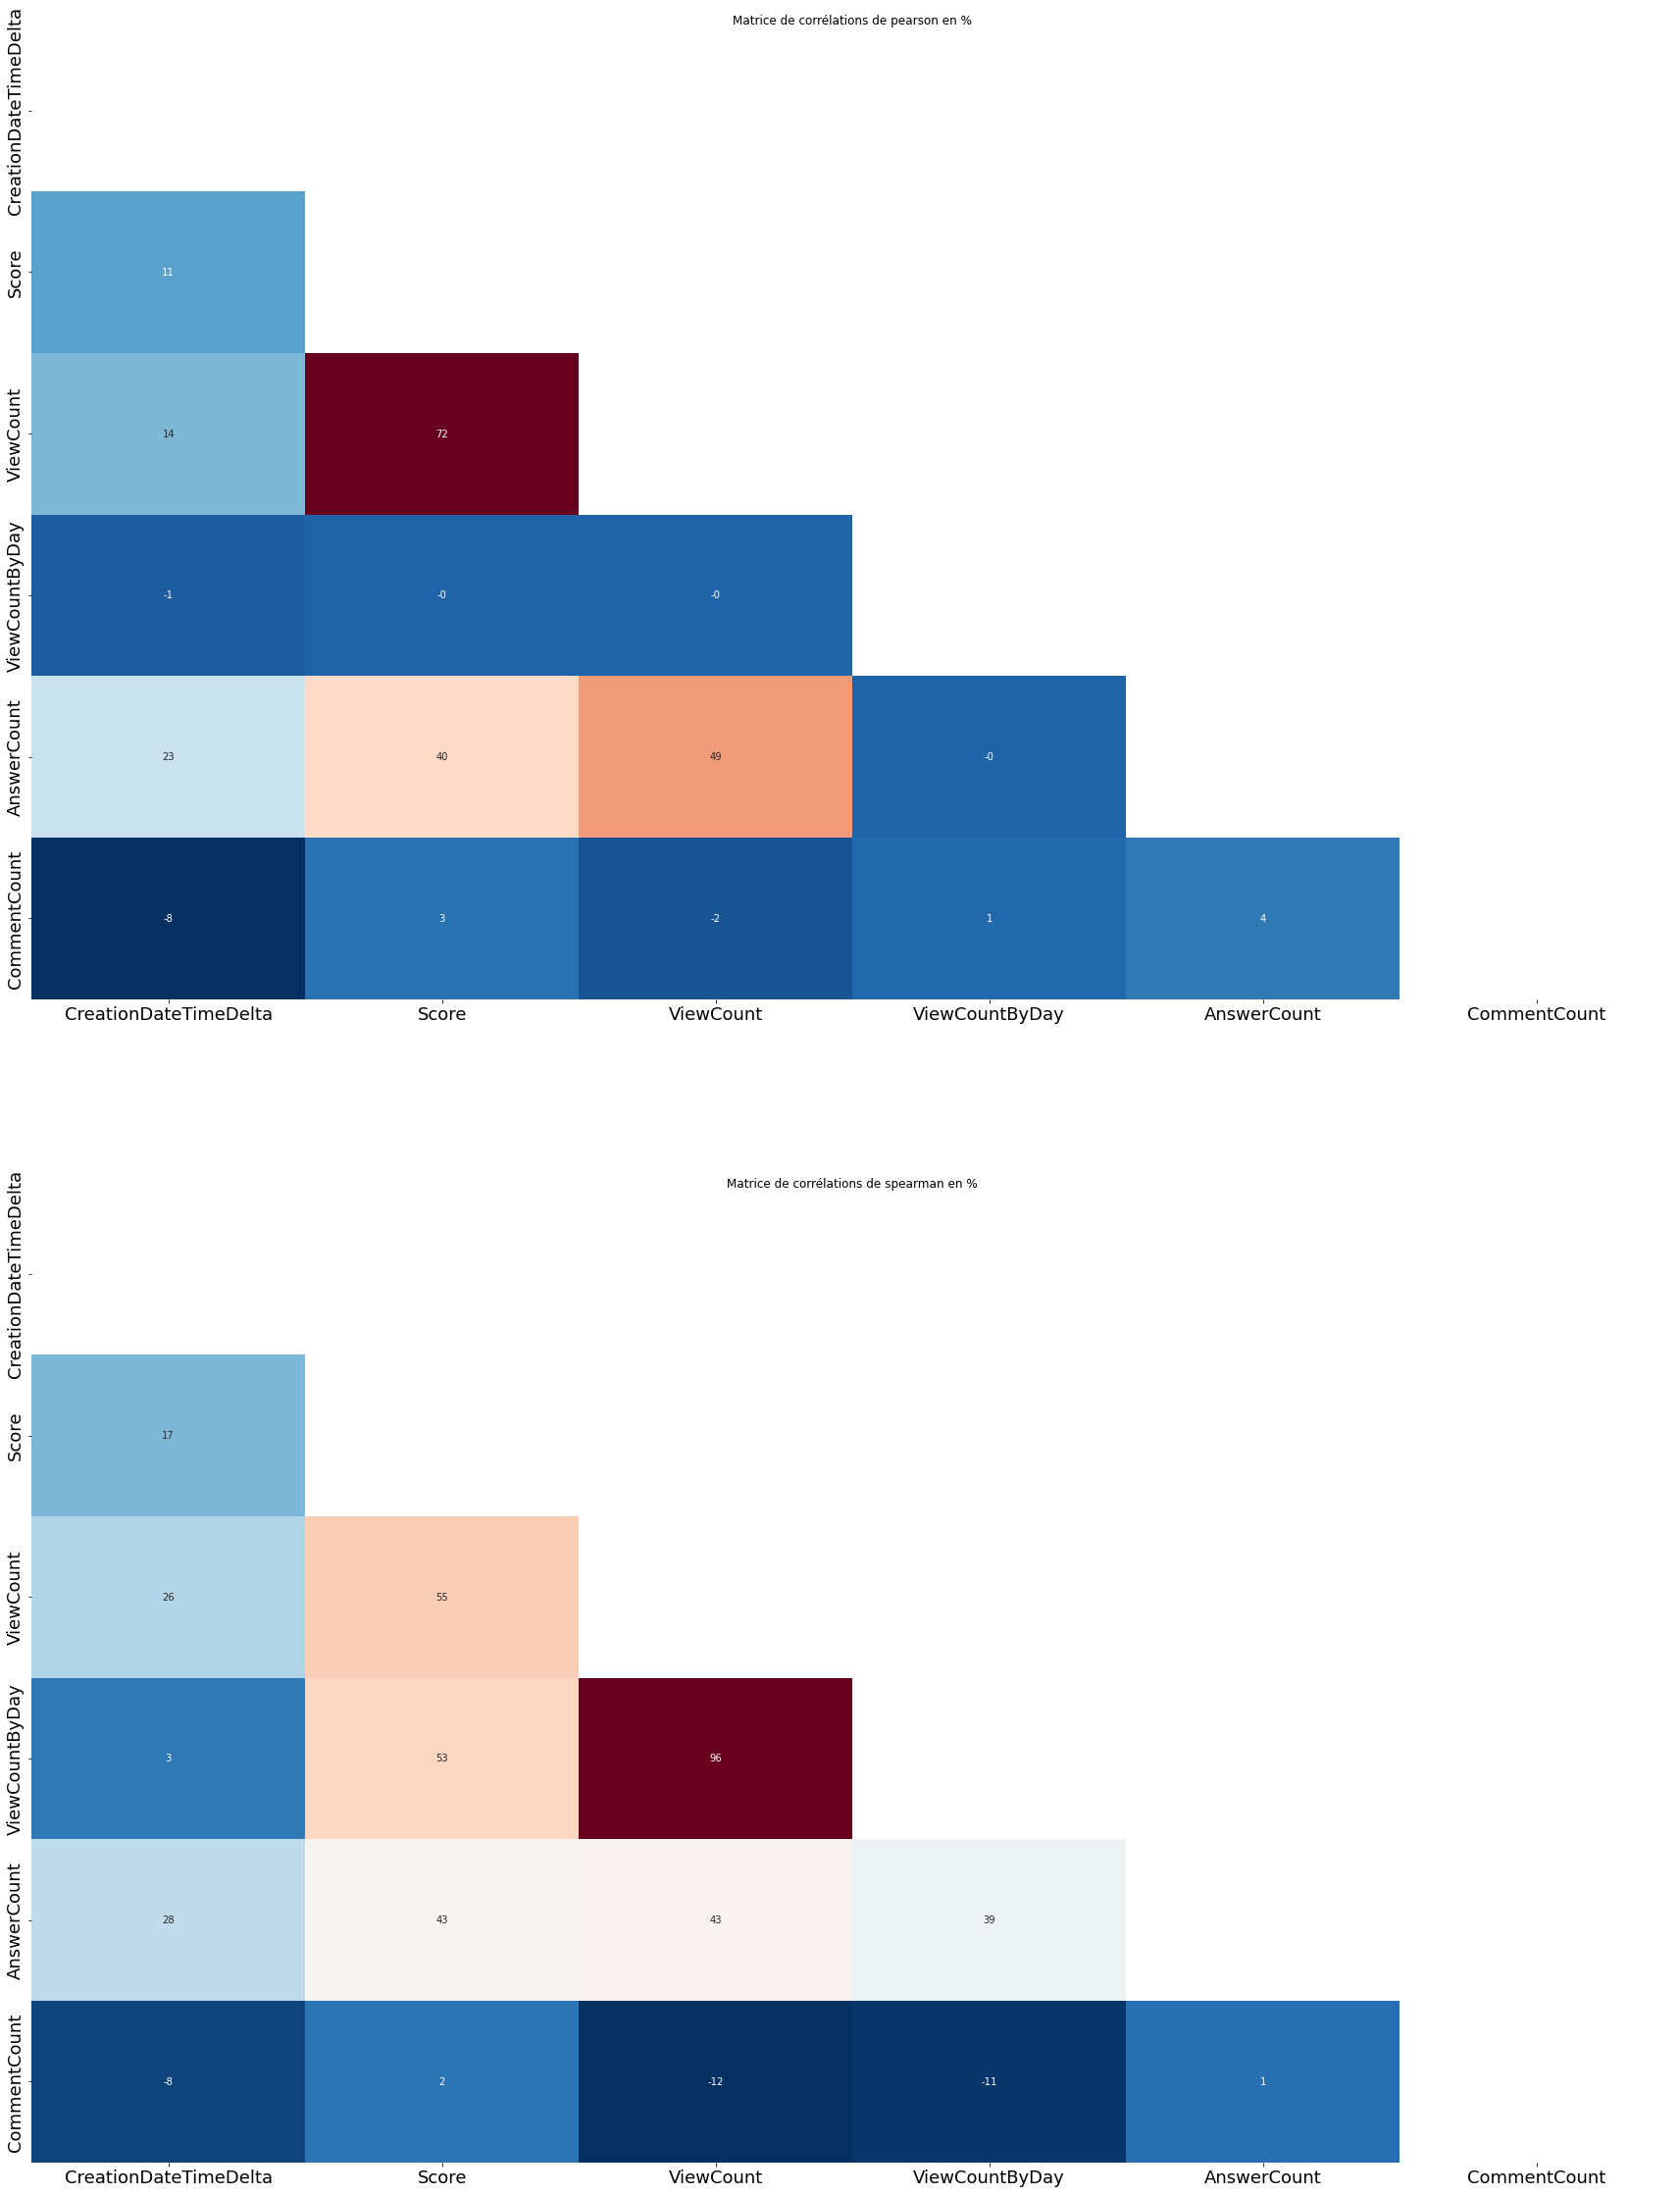

In [16]:
def correlations(data, methods):
    """
    Plot correlation matrix for quantitatives values.
    
    Args:
        data(dataframe): A dataframe
        
        method(string): CHosen method to compute correlation. Might be "pearson", "spearman" or "kendall"
        
    Returns:
        Correlation matrix
    """
    
    correlations = []
    cleanning_masks = []
    for method in methods: 
        correlation = data.select_dtypes(include=['int64','float64']).corr(method=method) * 100
        cleanning_mask = np.zeros_like(correlation)
        upper_triangle = np.triu_indices_from(correlation)
        cleanning_mask[upper_triangle] = 1
        correlations.append(correlation)
        cleanning_masks.append(cleanning_mask)

        
    fig, axes = plt.subplots(nrows=len(methods), figsize=(30,40))
    fig.subplots_adjust(wspace=0.2)

    for i in range(len(axes)):
        sns.heatmap(correlations[i], ax=axes[i], cmap="RdBu_r", mask = cleanning_masks[i], 
                   annot = True, fmt=".0f", cbar=False)

        axes[i].set_title(f"Matrice de corrélations de {methods[i]} en %")
        
  
    
correlations(data[["CreationDate","CreationDateTimeDelta","Score","ViewCount", "ViewCountByDay","AnswerCount","CommentCount"]], methods=["pearson", "spearman"])

Les visualisations permettent effectivement de constater des corrélations plus faibles avec la variable ViewCountByDay que VeiwCount . Nous décidons donc d’utiliser cette dernière. 

## Filtrage des données

### Count titles for each language


A présent, nous devons **vérifier si les textes des questions sont rédigés en diverses langues**. Cela nous permettra de définir la liste des stop words à éliminer :

##### Définition d'une fonction `detect_lang()` qui défini la langue de chaque individus.

In [17]:
import time
import datetime as dt
from datetime import date, timedelta

from langdetect import detect

In [18]:
# Create feature "lang" with langdetect library
def detect_lang(x):
    try:
        return detect(x)
    except:
        pass

start_time = time.time()
data['short_body'] = data['Body'].apply(lambda x: x[0:100])
data['lang'] =data.short_body.apply(detect_lang)
exec_time = time.time() - start_time
print('-' * 50)
print("Execution time : {:.2f}s".format(exec_time))
print('-' * 50)

--------------------------------------------------
Execution time : 363.94s
--------------------------------------------------


In [19]:
# Count titles for each language
pd.DataFrame(data.lang.value_counts())

,lang
en,102501
ca,476
fr,385
ro,188
pt,166
cy,141
it,140
da,111
nl,93
es,61


In [20]:
data = data[data["lang"] == "en"]

In [21]:
data.shape

(102501, 12)

Au vu de l'étude préalable nous décidons de placer un seuil à 0 pour les variables Socre, AnswerCount, CommentCount et FavoriteCount ainsi qu'un seuil à 5 pour ViewCountByDay.

In [22]:
filtered_data = data[(data['Score'] > 0) &
                           (data['AnswerCount']>0) &
                           (data['CommentCount']>0) &
                           (data['ViewCountByDay']>5)]
filtered_data.sort_values(['Score', 'ViewCount'], ascending=[False, False], inplace=True)
filtered_data_prop = round((filtered_data.shape[0] / data.shape[0] * 100),2)
display(filtered_data)
print(f"Porportion de données restantes: {filtered_data_prop}%")

filtered_data.to_csv('./data/filtered_data.csv')

,CreationDate,Title,Body,Tags,ViewCount,CommentCount,AnswerCount,Score,CreationDateTimeDelta,ViewCountByDay,short_body,lang
Id,,,,,,,,,,,,
11227809,2012-06-27 13:51:36,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,<java><c++><performance><cpu-architecture><bra...,1608838,9,26,25552,3635,442.596424,<p>Here is a piece of C++ code that shows some...,en
927358,2009-05-29 18:09:14,How do I undo the most recent local commits in...,<p>I accidentally <strong>committed the wrong ...,<git><version-control><git-commit><undo>,9565025,14,93,22708,4760,2009.459034,<p>I accidentally <strong>committed the wrong ...,en
2003505,2010-01-05 01:12:15,How do I delete a Git branch locally and remot...,<p>I want to delete a branch both locally and ...,<git><version-control><git-branch><git-push><g...,8827030,11,40,18011,4539,1944.708085,<p>I want to delete a branch both locally and ...,en
1125968,2009-07-14 14:58:15,"How do I force ""git pull"" to overwrite local f...",<p>How do I force an overwrite of local files ...,<git><version-control><overwrite><git-pull><gi...,5760667,8,50,8029,4714,1222.033729,<p>How do I force an overwrite of local files ...,en
4114095,2010-11-06 16:58:14,How do I revert a Git repository to a previous...,<p>How do I revert from my current state to a ...,<git><git-checkout><git-reset><git-revert>,7096625,8,41,7624,4234,1676.104157,<p>How do I revert from my current state to a ...,en
...,...,...,...,...,...,...,...,...,...,...,...,...
72467333,2022-06-01 19:50:31,C++17: Deducing function noexcept specifier as...,<p>I've noticed that MSVC sometimes fails to d...,<c++><templates><c++17><noexcept>,133,7,2,6,8,16.625000,<p>I've noticed that MSVC sometimes fails to d...,en
72383571,2022-05-25 20:03:30,Deducing a shared base of two classes in C++,<p>I am almost certain that what I'm looking f...,<c++><typetraits><c++-experimental>,116,11,2,6,15,7.733333,<p>I am almost certain that what I'm looking f...,en
72362798,2022-05-24 12:20:28,ZonedDateTime format and parsing exception wit...,<p>I have a problem with parsing <code>ZonedDa...,<java><java-time><datetime-parsing><zoneddatet...,104,12,2,6,17,6.117647,<p>I have a problem with parsing <code>ZonedDa...,en


Porportion de données restantes: 35.01%


In [23]:
data.shape

(102501, 12)

#### Vérification de la période d'étallement de notre base de données suite aux dernières suppressions d'individus :

In [24]:
time_delta = int(
    (data["CreationDate"].max() - data["CreationDate"].min()) / np.timedelta64(1, "Y")
)
print(
    "La période dont nous disposons est de",
    time_delta,
    "ans complet, elle commence le",
    data["CreationDate"].min(),
    "et se termine le",
    data["CreationDate"].max(),
    ".",
)

La période dont nous disposons est de 13 ans complet, elle commence le 2009-01-01 17:12:12 et se termine le 2022-06-10 19:00:02 .


## <span style="color: lightgreen" >Analyse des variables qualitatives :</span>

Nous allons à présent vérifier la **longeur des différents titres** de la base :

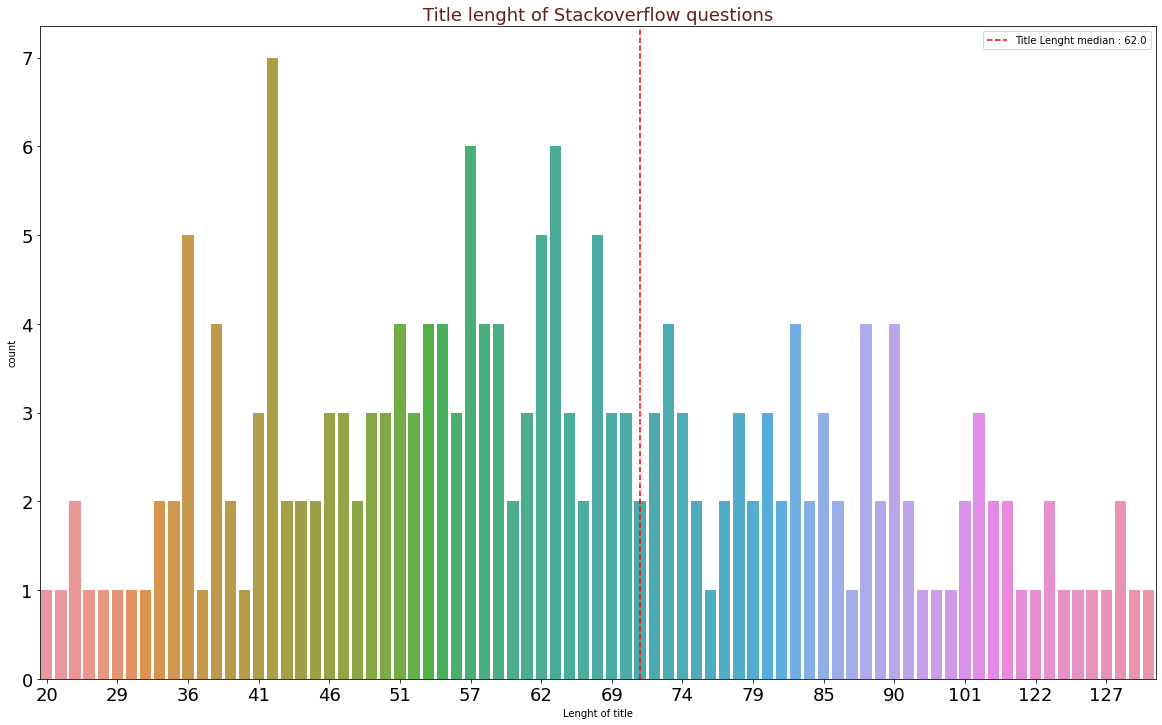

In [25]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=df.Title.str.len())
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 5))
plt.axvline(df.Title.str.len().median() - df.Title.str.len().min(),
            color="r", linestyle='--',
            label="Title Lenght median : "+str(df.Title.str.len().median()))
ax.set_xlabel("Lenght of title")
plt.title("Title lenght of Stackoverflow questions",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

Nous allons également ploter la répartition des **longueurs de la variable** `Body` *(les corps de texte des questions)*. L'étendue étant très importante, nous allons dans un premier temps **discrétiser ces longueur** pour ne pas surcharger les temps de calculs de projection graphique :

In [26]:
from sklearn.preprocessing import KBinsDiscretizer
# Discretizer for Body characters lenght
X = pd.DataFrame(df.Body.str.len())

# Sklearn discretizer with 200 bins
discretizer = KBinsDiscretizer(n_bins=50,
                               encode='ordinal',
                               strategy='uniform')
body_lenght = discretizer.fit_transform(X)
body_lenght = discretizer.inverse_transform(body_lenght)
body_lenght = pd.Series(body_lenght.reshape(-1))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


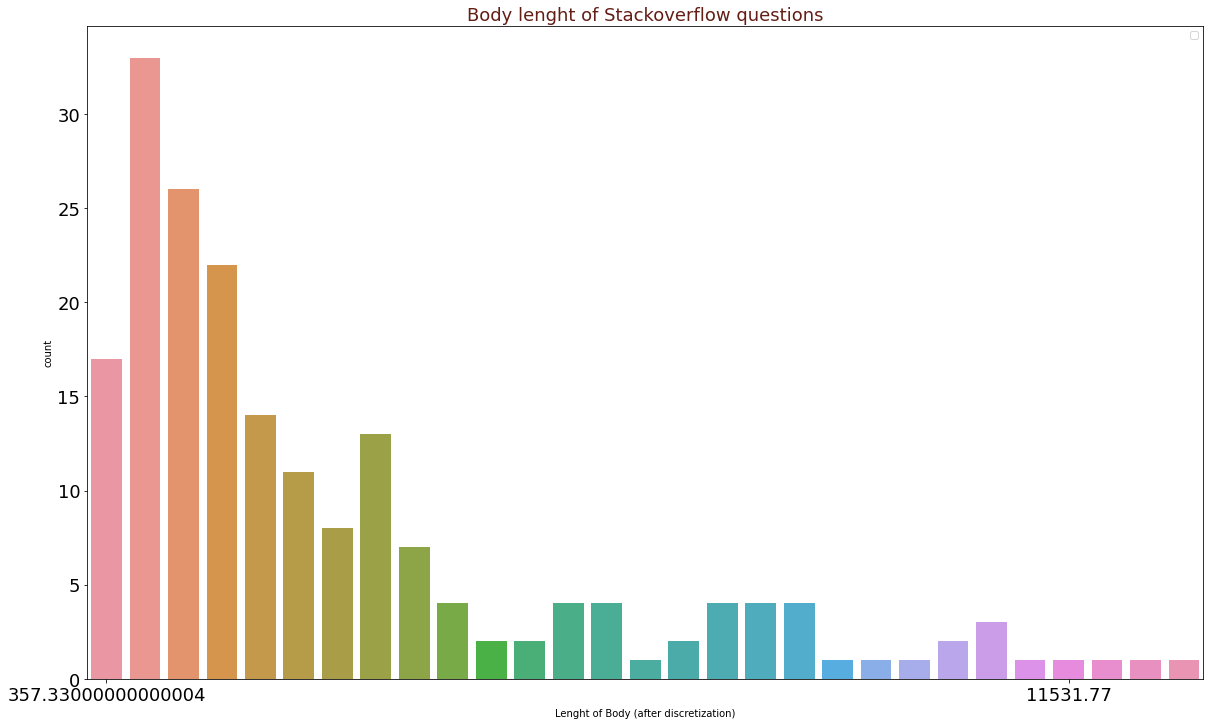

In [27]:
fig = plt.figure(figsize=(20, 12))
ax = sns.countplot(x=body_lenght)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(0, end, 25))
ax.set_xlabel("Lenght of Body (after discretization)")
plt.title("Body lenght of Stackoverflow questions",
          fontsize=18, color="#641E16")
plt.legend()
plt.show()

### Analyse des tags
Nous allons faire une rapide analyse exploratoire sur les tags du jeu de données.

In [28]:
filtered_data['Tags'].head(20)

Id
11227809    <java><c++><performance><cpu-architecture><bra...
927358               <git><version-control><git-commit><undo>
2003505     <git><version-control><git-branch><git-push><g...
1125968     <git><version-control><overwrite><git-pull><gi...
4114095            <git><git-checkout><git-reset><git-revert>
1783405                    <git><git-checkout><remote-branch>
1274057                              <git><gitignore><git-rm>
2025282     <android><android-layout><user-interface><dime...
16956810                 <linux><text><grep><directory><find>
630453                                <http><rest><post><put>
826782         <css><cross-browser><highlight><textselection>
417142                                   <http><url><browser>
487258      <algorithm><complexity-theory><computer-scienc...
901712                   <javascript><jquery><html><checkbox>
3737139           <php><arguments><logic><operators><symbols>
4456438     <apache-flex><actionscript><soap><coldfusion><...
40623

Nous allons modifier les séparateurs de Tags pour favoriser les extractions :

In [29]:
# Replace open and close balise between tags
filtered_data['Tags'] = filtered_data['Tags'].str.translate(str.maketrans({'<': '', '>': ','}))

# Delete last "," for each row
filtered_data['Tags'] = filtered_data['Tags'].str[:-1]
filtered_data['Tags'].head(20)

Id
11227809    java,c++,performance,cpu-architecture,branch-p...
927358                    git,version-control,git-commit,undo
2003505     git,version-control,git-branch,git-push,git-re...
1125968      git,version-control,overwrite,git-pull,git-fetch
4114095                 git,git-checkout,git-reset,git-revert
1783405                        git,git-checkout,remote-branch
1274057                                  git,gitignore,git-rm
2025282     android,android-layout,user-interface,dimensio...
16956810                       linux,text,grep,directory,find
630453                                     http,rest,post,put
826782              css,cross-browser,highlight,textselection
417142                                       http,url,browser
487258      algorithm,complexity-theory,computer-science,b...
901712                        javascript,jquery,html,checkbox
3737139                 php,arguments,logic,operators,symbols
4456438         apache-flex,actionscript,soap,coldfusion,wsdl
40623

Les tags contenus dans la variable `Tags` sont ensuite splités et ajoutés dans une liste pour ensuite les classer :

In [30]:
def count_split_tags(df, column, separator):
    """This function allows you to split the different words contained
    in a Pandas Series cell and to inject them separately into a list.
    This makes it possible, for example, to count the occurrences of words.

    Parameters
    ----------------------------------------
    df : Pandas Dataframe
        Dataframe to use.
    column : string
        Column of the dataframe to use
    separator : string
        Separator character for str.split.
    ----------------------------------------
    """
    list_words = []
    for word in df[column].str.split(separator):
        list_words.extend(word)
    df_list_words = pd.DataFrame(list_words, columns=["Tag"])
    df_list_words = df_list_words.groupby("Tag")\
        .agg(tag_count=pd.NamedAgg(column="Tag", aggfunc="count"))
    df_list_words.sort_values("tag_count", ascending=False, inplace=True)
    return df_list_words

In [31]:
tags_list = count_split_tags(df=filtered_data, column='Tags', separator=',')
print("Le jeu de données compte {} tags.".format(tags_list.shape[0]))

Le jeu de données compte 9845 tags.


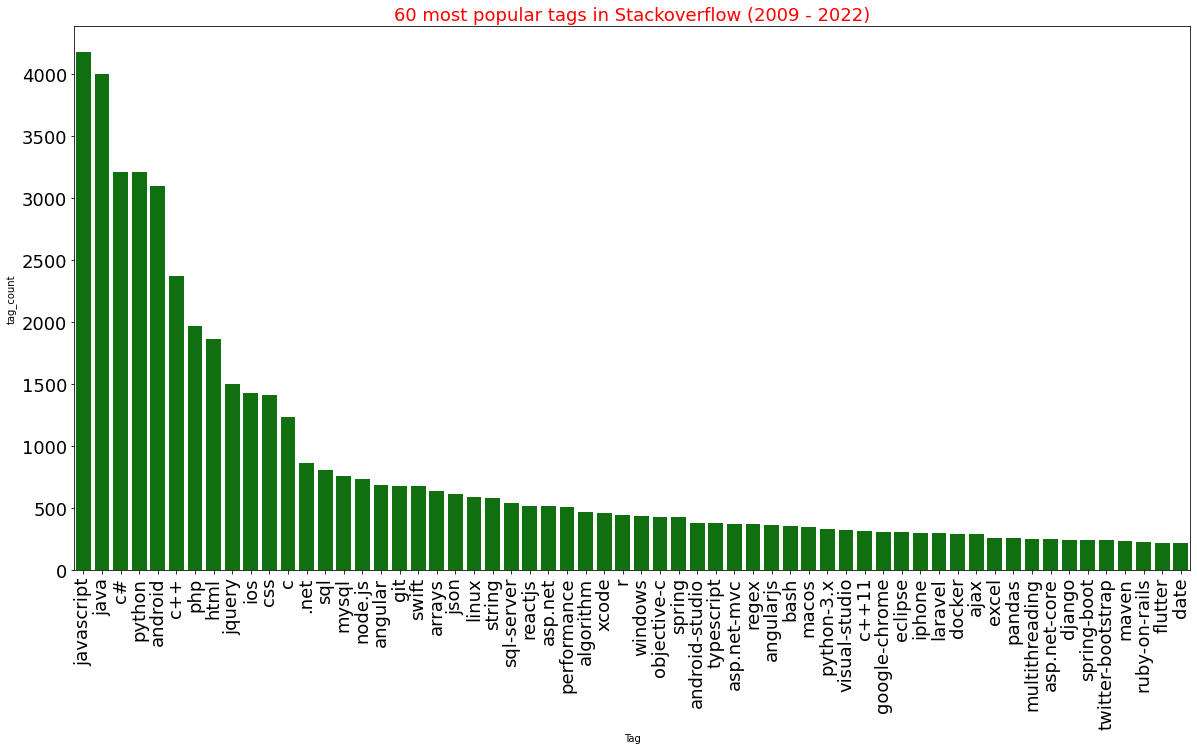

In [32]:
# Plot the results of splits
fig = plt.figure(figsize=(20, 10))
sns.barplot(data=tags_list.iloc[0:60, :],
            x=tags_list.iloc[0:60, :].index,
            y="tag_count", color="green")
plt.xticks(rotation=90)
plt.title("60 most popular tags in Stackoverflow (2009 - 2022)",
          fontsize=18, color='red')
plt.show()

Dans les 40 tags les plus populaires sur StackOverflow, les tags **C++**, **C#** et **java** sont sans surprise dans le top 3. Le dataset compte **plus de 11 051 tags** différents pour la période 2009 - 2022. 

Nous pouvons également **visualiser les 500 premières catégories dans un nuage de mots** :

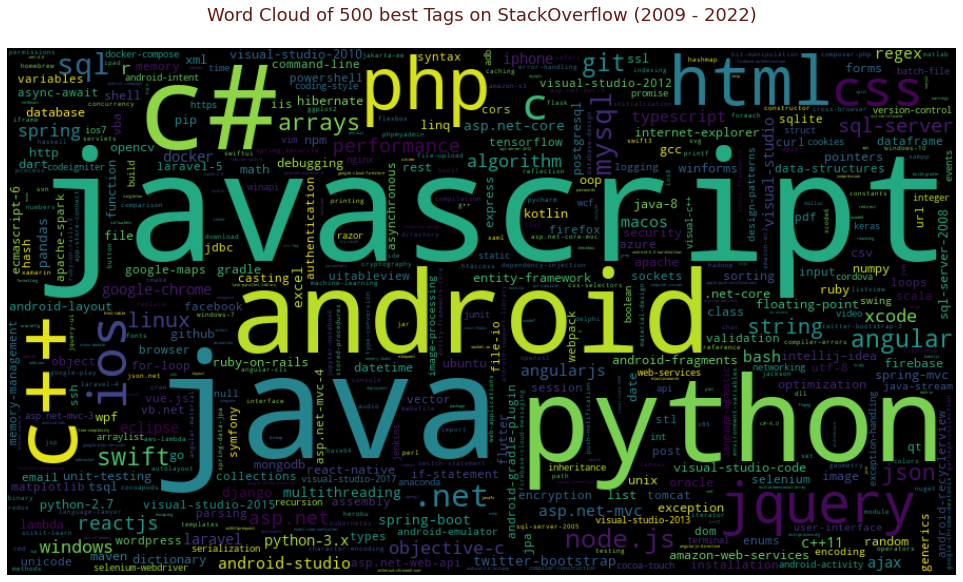

In [33]:
# Plot word cloud with tags_list (frequencies)
fig = plt.figure(1, figsize=(17, 12))
ax = fig.add_subplot(1, 1, 1)
wordcloud = WordCloud(width=900, height=500,
                      background_color="black",
                      max_words=500, relative_scaling=1,
                      normalize_plurals=False)\
    .generate_from_frequencies(tags_list.to_dict()['tag_count'])

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
plt.title("Word Cloud of 500 best Tags on StackOverflow (2009 - 2022)\n",
          fontsize=18, color="#641E16")
plt.show()

Il peut être intéressant de regarder si ces tags populaires ont évolués au fil du temps. Prenons par exemple les années 2009, 2011, 2013, 2015, 2017, 2019, 2021 et 2022 pour vérifier.

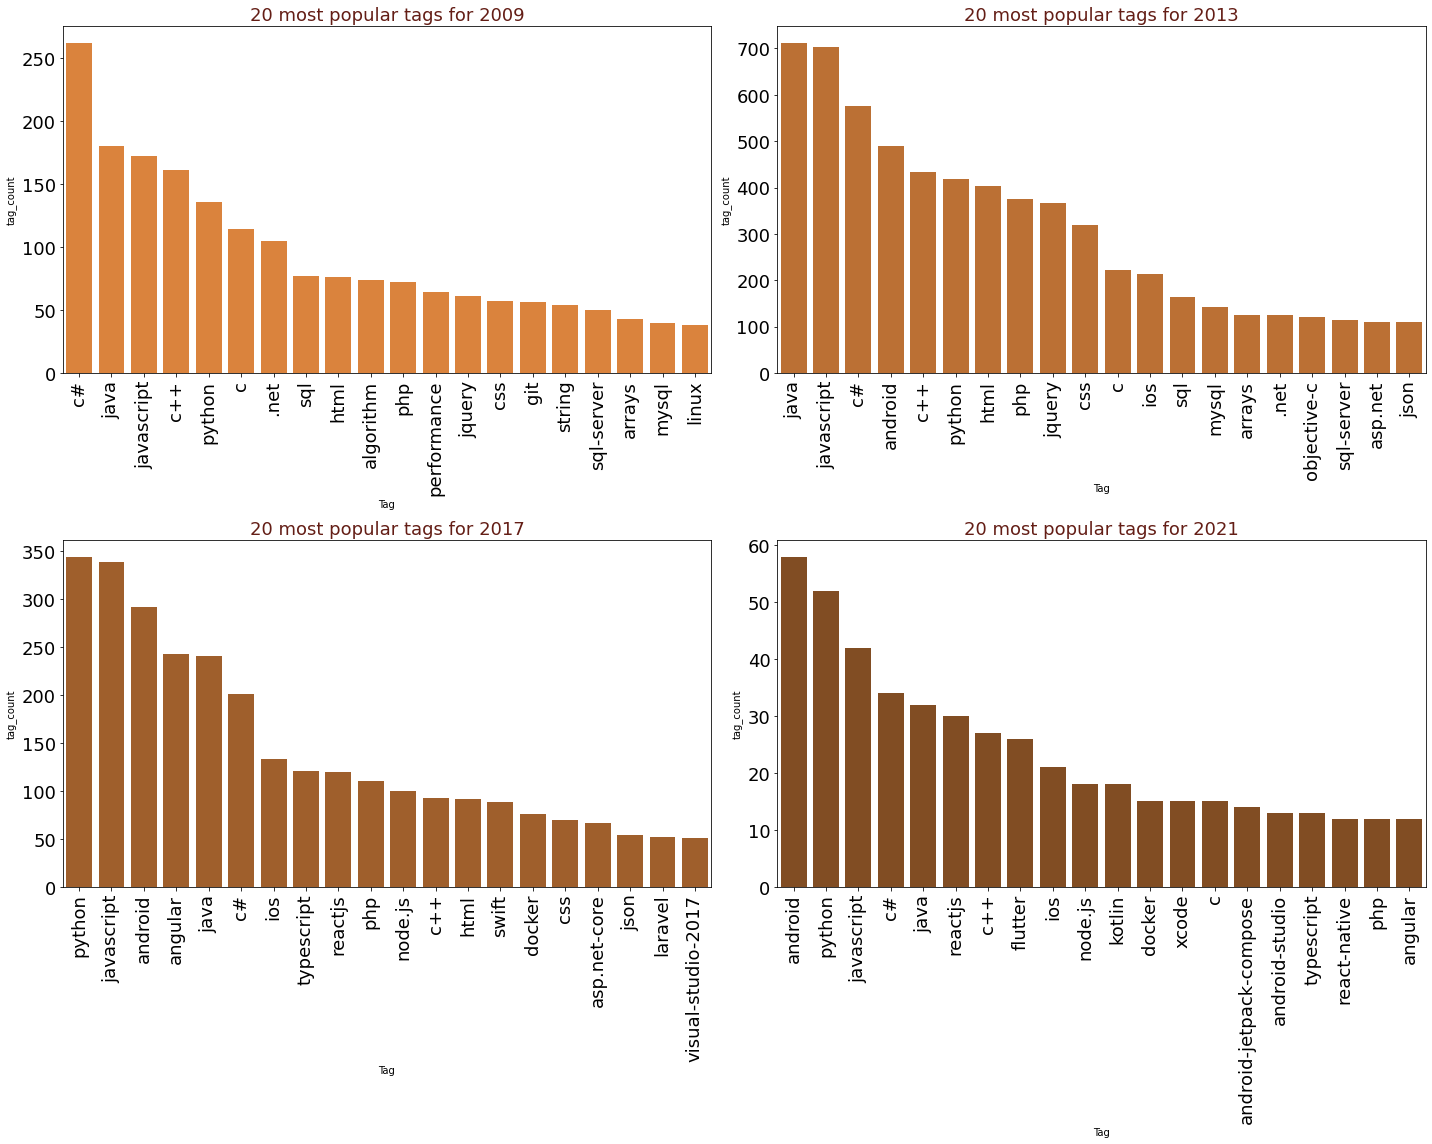

In [34]:
# Subplots parameters
years = {0: 2009, 1: 2013, 2: 2017, 3: 2021}
colors = {0: "#f48023", 1: "#d16e1e",
          2: "#b25d19", 3: "#904b14"}
subplots = 4
cols = 2
rows = subplots // cols
rows += subplots % cols
position = range(1, subplots + 1)

# Plot popular tags for each year
fig = plt.figure(1, figsize=(20, 16))
for k in range(subplots):
    subset = filtered_data[filtered_data["CreationDate"].dt.year == years[k]]
    temp_list = count_split_tags(df=subset, column='Tags', separator=',')
    ax = fig.add_subplot(rows, cols, position[k])
    sns.barplot(data=temp_list.iloc[0:20, :],
            x=temp_list.iloc[0:20, :].index,
            y="tag_count", color=colors[k])
    plt.xticks(rotation=90)
    ax.set_title("20 most popular tags for {}".format(years[k]),
                 fontsize=18, color="#641E16")

fig.tight_layout()
plt.show()

On remarque en effet que les centres d'intérêt évoluent en fonction des années. Cependant, on retrouve les principaux languages et framework informatiques dans les premières places.     

Nous allons a présent regarder le **nombre de Tags par question** :

In [35]:
# Create a list of Tags and count the number
filtered_data['Tags_list'] = filtered_data['Tags'].str.split(',')
filtered_data['Tags_count'] = filtered_data['Tags_list'].apply(lambda x: len(x))

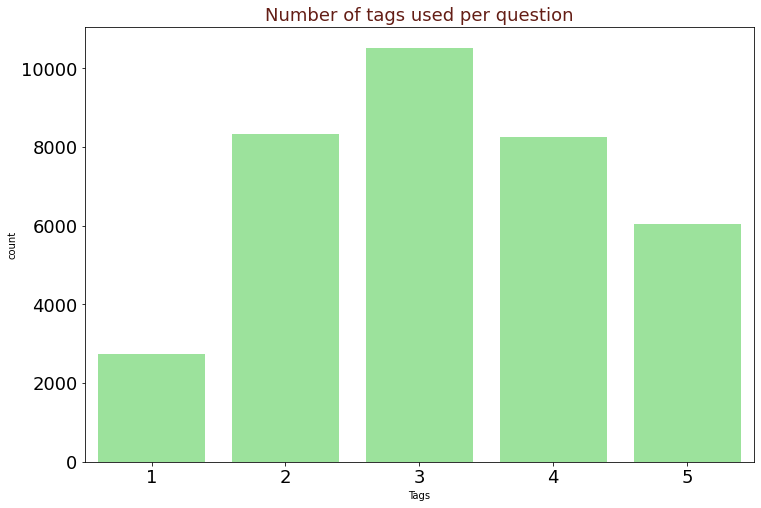

In [36]:
# Plot the result
fig = plt.figure(figsize=(12, 8))
ax = sns.countplot(x=filtered_data.Tags_count, color="lightgreen")
ax.set_xlabel("Tags")
plt.title("Number of tags used per question",
          fontsize=18, color="#641E16")
plt.show()

Pour la majorité des questions StackOverflow analysées, 3 tags sont utilisés. Cela nous donne déjà une indication sur le type de modélisation à mettre en oeuvre.